In [10]:
### From 2023 SD-1042 data: compute tau from wind velocity & plot current velocity
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import cftime
import sys
from metpy.calc import wind_components, density, mixing_ratio_from_relative_humidity, wind_direction
from metpy.units import units
from oceans.ocfis import spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc
from convert_dir import vector_dir_to_from
from bipolar import bipolar

In [14]:
### merged nc file info
year = '2023'
platf_num = '1042'
path_airsea = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
# tlim_plot = [datetime.datetime(int(year),10,17), datetime.datetime(int(year),11,17)] ### 2023 SD1042
# tlim_plot = [datetime.datetime(int(year),8,1), datetime.datetime(int(year),10,24)] ### 2023 SD1031
tlim_plot = [datetime.datetime(int(year),10,24), datetime.datetime(int(year),10,25)] ### 2022 SD1042 BT
if (tlim_plot[1]-tlim_plot[0]).days > 2:
    nt_plot = (tlim_plot[1]-tlim_plot[0]).days
    tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nt_plot)]
    str_fmt = '%m/%d'
else:
    nint = 2
    nt_plot = int( (tlim_plot[1]-tlim_plot[0]).total_seconds()/3600/nint )
    str_fmt = '%m/%d %H'
    tticks = [tlim_plot[0]+datetime.timedelta(hours=nint*i) for i in range(nt_plot)]
tticks_label = [tticks[i].strftime(str_fmt) for i in range(len(tticks))]

### load airsea data
ds_airsea = nc.Dataset(path_airsea+'airsea-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_airsea.variables['time'][:]
print(ds_airsea.variables['time'].units)
dtime_airsea = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uwnd = ds_airsea.variables['UWND_MEAN'][:]
vwnd = ds_airsea.variables['VWND_MEAN'][:]
bp = ds_airsea.variables['BARO_PRES_MEAN'][:]
RH = ds_airsea.variables['RH_MEAN'][:]
airT = ds_airsea.variables['TEMP_AIR_MEAN'][:]
print('airsea data time:',dtime_airsea.shape, uwnd.shape)
### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
print(ds_adcp.variables['time'].units)
dtime_adcp = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
u = ds_adcp.variables['vel_east'][:]*100 # cm/s
v = ds_adcp.variables['vel_north'][:]*100
depth = ds_adcp.variables['depth'][:]
data_flag = ds_adcp.variables['data_flag'][:]
print('adcp depth, time, u:',depth.shape, dtime_adcp.shape, u.shape)
### assign nan to flags
u[data_flag >0] = np.nan
v[data_flag >0] = np.nan

seconds since 2023-01-01
airsea data time: (44040,) (44040,)
seconds since 2023-01-01
adcp depth, time, u: (50,) (6154,) (6154, 50)


airsea: [datetime.datetime(2023, 10, 17, 10, 0)
 datetime.datetime(2023, 10, 17, 10, 1)
 datetime.datetime(2023, 10, 17, 10, 2)] [60. 60. 60.] secconds
adcp: [datetime.datetime(2023, 10, 18, 0, 0)
 datetime.datetime(2023, 10, 18, 0, 5)
 datetime.datetime(2023, 10, 18, 0, 10)] [300. 300. 300.] secconds


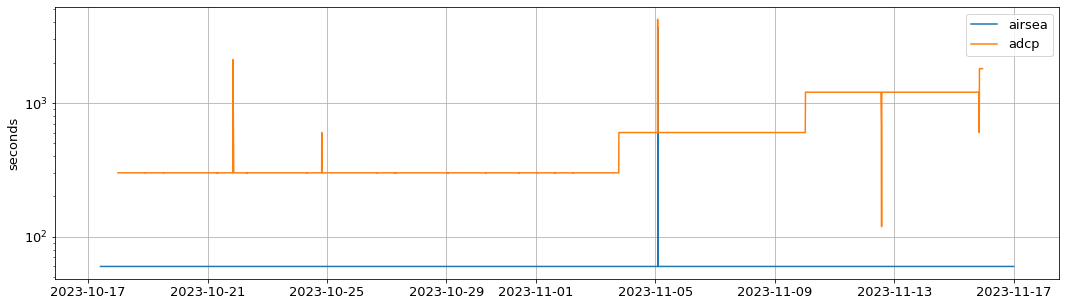

In [15]:
### the time intervals between measurements
plt.gcf().set_size_inches(18, 5)
### airsea data
timestamp = np.array( [dtime_airsea[i].timestamp() for i in range( len(dtime_airsea) )] )
print('airsea:',dtime_airsea[0:3],np.diff(timestamp)[0:3],'secconds')
plt.semilogy( dtime_airsea[:-1], np.diff(timestamp),label='airsea' )
### adcp data
timestamp = np.array( [dtime_adcp[i].timestamp() for i in range( len(dtime_adcp) )] )
print('adcp:',dtime_adcp[0:3],np.diff(timestamp)[0:3],'secconds')
plt.semilogy( dtime_adcp[:-1], np.diff(timestamp),label='adcp' )
# plt.ylim([1e3,4e6])
plt.ylabel('seconds')
plt.grid()
plt.legend()

In [16]:
### compute current direction from
iz = np.argmin( depth ) ### depth indice to plot
cur_dir_from = np.nan*np.ones(dtime_adcp.shape)
for i in range( len(dtime_adcp) ):
    _, cur_dir_from[i] = vector_dir_to_from(u[i,iz],v[i,iz])

### compute wind direction from
wind_dir_from = np.nan*np.ones(dtime_airsea.shape)
for i in range( len(dtime_airsea) ):
    _, wind_dir_from[i] = vector_dir_to_from(uwnd[i], vwnd[i])

<Figure size 432x288 with 0 Axes>

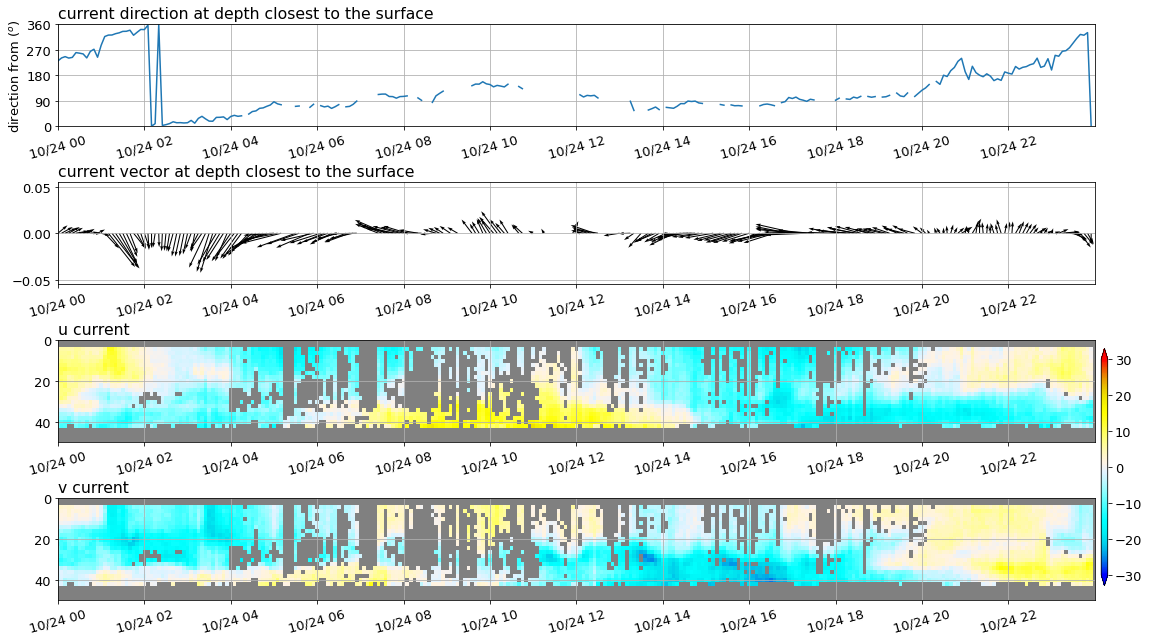

In [17]:
### plot current velocity time-depth contour plot
vellim = [-30,30]
# cmap = 'bwr'
cmap = bipolar(neutral=0.95)
nrow = 4
itcur = np.where( (dtime_adcp>= tlim_plot[0]) & (dtime_adcp< tlim_plot[1]) )[0]
### plot
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 10)
plt.rcParams.update({'font.size': 13})
### current direction from (meteorological convention) at the depth closest the surface
plt.subplot(nrow,1,1)
plt.plot(dtime_adcp[itcur],cur_dir_from[itcur])
plt.ylim([0,360]); plt.yticks(np.arange(0,450,90))
plt.ylabel('direction from ($^o$)')
plt.title('current direction at depth closest to the surface',loc='left')
### quiver plot at the depth closest the surface
plt.subplot(nrow,1,2)
# plt.quiver(dtime_adcp[itcur[::6]],np.zeros((len(itcur[::6]),)),u[itcur[::6],iz],v[itcur[::6],iz],\
#            scale=500,width=0.001)
plt.quiver(dtime_adcp[itcur],np.zeros((len(itcur),)),u[itcur,iz],v[itcur,iz],\
           scale=500,width=0.001)
plt.title('current vector at depth closest to the surface',loc='left')
### u
plt.subplot(nrow,1,3)
cs = plt.pcolormesh(dtime_adcp[itcur], depth, u[itcur,:].transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
plt.title('u current',loc='left')
cbar_ax = fig.add_axes([.905,.12,.005,.33])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
### v
plt.subplot(nrow,1,4)
plt.pcolormesh(dtime_adcp[itcur], depth, v[itcur,:].transpose(),label='v',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
plt.title('v current',loc='left')
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=15)
    if i > 1:
        plt.ylim([0,50])
        plt.gca().invert_yaxis()
        plt.gca().set_facecolor('gray')
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)    
    plt.grid()
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.55)
### save figure
plt.savefig('timeseries_current(QC)_SD'+platf_num+'_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')\
            +'.png',dpi=400,bbox_inches='tight')

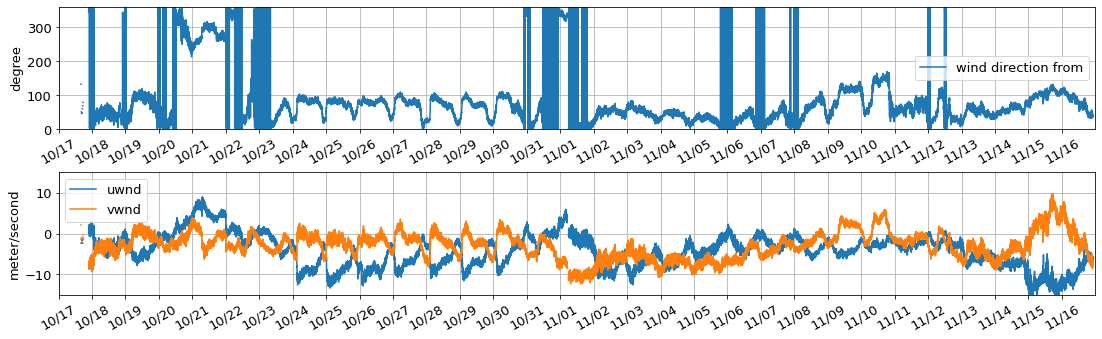

In [13]:
### plot (1) wind direction from (2) u & v wind time series
nrow = 2
itairsea = np.where( (dtime_airsea>= tlim_plot[0]) & (dtime_airsea< tlim_plot[1]) )[0]
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.subplot(nrow,1,1)
plt.plot(dtime_airsea[itairsea],wind_dir_from[itairsea],label='wind direction from')
plt.ylim([0,360])
plt.ylabel('degree')
plt.subplot(nrow,1,2)
plt.plot(dtime_airsea[itairsea], uwnd[itairsea],label='uwnd')
plt.plot(dtime_airsea[itairsea], vwnd[itairsea],label='vwnd')
plt.ylim([-15,15])
plt.ylabel('meter/second')
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    plt.legend()
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
plt.savefig('timeseries_wind_SD'+platf_num+'_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')\
            +'.png',dpi=300,bbox_inches='tight')

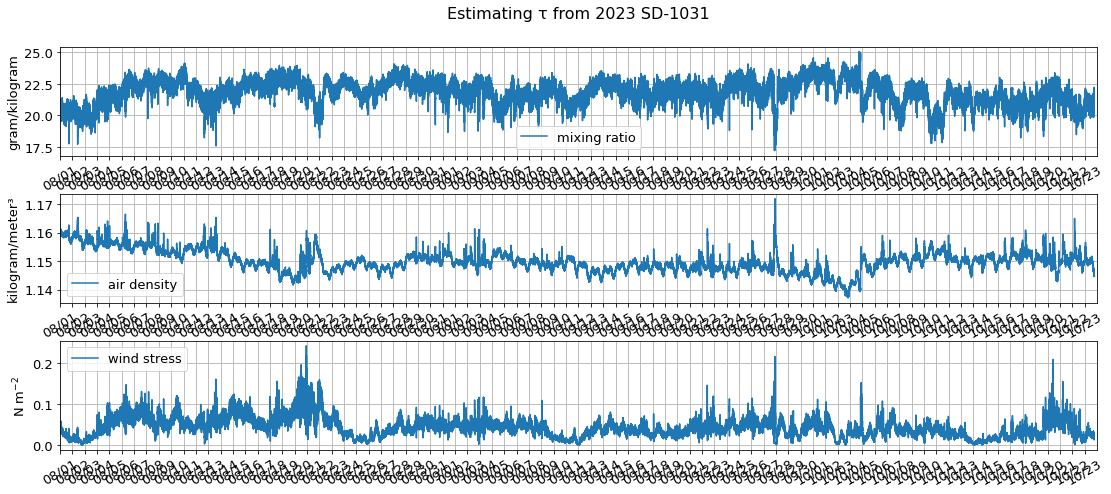

In [46]:
### compute air density (need specific humidity -> mixing ratio, air pressure), wind stress
mixing_ratio = mixing_ratio_from_relative_humidity\
    (bp.filled()*units.hPa,airT.filled()*units.degC,RH.filled()*units.percent).to('g/kg') # specific humidity
roh = density(bp.filled()*units.hPa, airT.filled()*units.degC, mixing_ratio)
taux, tauy = ra_windstr_nc(np.array(uwnd),np.array(vwnd),1.2)
tau = np.sqrt( np.square(taux)+ np.square(tauy) )

### plot (1) specific humidity, mixing ratio (2) air density (3) wind stress
nrow = 3
itairsea = np.where( (dtime_airsea>= tlim_plot[0]) & (dtime_airsea< tlim_plot[1]) )[0]
plt.clf()
plt.gcf().set_size_inches(18, 7)
plt.rcParams.update({'font.size': 13})
plt.subplot(nrow,1,1)
# plt.plot(dtime_airsea[itairsea], sh[itmet],label='specific humidity')
plt.plot(dtime_airsea[itairsea],mixing_ratio[itairsea],label='mixing ratio')
plt.subplot(nrow,1,2)
plt.plot(dtime_airsea[itairsea], roh[itairsea],label='air density')
plt.subplot(nrow,1,3)
plt.plot(dtime_airsea[itairsea], tau[itairsea], label='wind stress')
plt.ylabel('N m$^{-2}$')
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.grid()
    plt.legend(loc='best')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
plt.suptitle('Estimating \N{GREEK SMALL LETTER TAU} from '+year+' SD-'+platf_num,fontsize=16)
### save figure
plt.savefig('timeseries_tau_SD-'+platf_num+'_'+tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')\
            +'.png',dpi=300,bbox_inches='tight')

In [29]:
type(mixing_ratio)

pint.quantity.build_quantity_class.<locals>.Quantity